# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


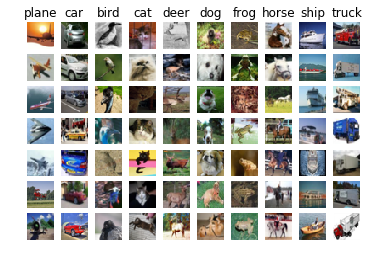

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


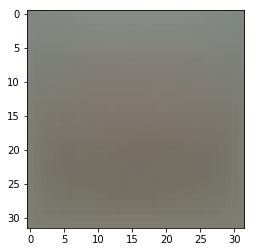

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.234962


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.445720 analytic: 6.445720, relative error: 5.800060e-11
numerical: 4.559502 analytic: 4.508119, relative error: 5.666639e-03
numerical: 1.814777 analytic: 1.814777, relative error: 1.016025e-11
numerical: 2.440000 analytic: 2.440000, relative error: 1.266716e-10
numerical: -8.111159 analytic: -8.130291, relative error: 1.177989e-03
numerical: -25.398715 analytic: -25.398715, relative error: 6.753995e-13
numerical: 4.412170 analytic: 4.412170, relative error: 6.819406e-12
numerical: 1.468102 analytic: 1.468102, relative error: 2.102669e-10
numerical: 11.559370 analytic: 11.559370, relative error: 5.534391e-11
numerical: -7.800606 analytic: -7.829600, relative error: 1.855022e-03
numerical: -3.347351 analytic: -3.347351, relative error: 1.131319e-10
numerical: -12.047949 analytic: -12.047949, relative error: 1.361658e-11
numerical: 11.245862 analytic: 11.245862, relative error: 1.685830e-11
numerical: -16.470931 analytic: -16.470931, relative error: 1.802884e-11
numerical: 3

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [24]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.234962e+00 computed in 0.116611s
Vectorized loss: 9.234962e+00 computed in 0.010612s
difference: -0.000000


In [25]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.120088s
Vectorized loss and gradient: computed in 0.009745s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [31]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.676286
iteration 100 / 1500: loss 242.502211
iteration 200 / 1500: loss 148.035264
iteration 300 / 1500: loss 90.477961
iteration 400 / 1500: loss 56.269545
iteration 500 / 1500: loss 35.992428
iteration 600 / 1500: loss 23.581729
iteration 700 / 1500: loss 16.366906
iteration 800 / 1500: loss 11.946959
iteration 900 / 1500: loss 9.726536
iteration 1000 / 1500: loss 8.007363
iteration 1100 / 1500: loss 6.770665
iteration 1200 / 1500: loss 5.867596
iteration 1300 / 1500: loss 5.351053
iteration 1400 / 1500: loss 5.277095
That took 6.217546s


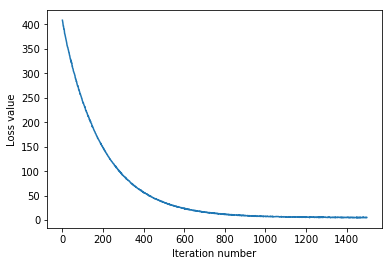

In [32]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381429
validation accuracy: 0.375000


In [40]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
iters = 1500
for lr in learning_rates:
    for reg in regularization_strengths:
        svm_t = LinearSVM()
        svm_t.train(X_train, y_train, 
                    learning_rate=lr, reg=reg,
                    num_iters=iters, verbose=True)
        
        y_train_pred = svm_t.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm_t.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        # 给字典赋值
        results[(lr, reg)] = (acc_train, acc_val)

        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm_t
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 176.826164
iteration 100 / 1500: loss 134.780785
iteration 200 / 1500: loss 109.843085
iteration 300 / 1500: loss 90.855800
iteration 400 / 1500: loss 74.392183
iteration 500 / 1500: loss 61.570391
iteration 600 / 1500: loss 51.415721
iteration 700 / 1500: loss 42.867130
iteration 800 / 1500: loss 35.551331
iteration 900 / 1500: loss 29.929301
iteration 1000 / 1500: loss 24.161923
iteration 1100 / 1500: loss 21.157193
iteration 1200 / 1500: loss 18.496281
iteration 1300 / 1500: loss 16.247055
iteration 1400 / 1500: loss 14.231897
iteration 0 / 1500: loss 330.220687
iteration 100 / 1500: loss 214.208756
iteration 200 / 1500: loss 143.855533
iteration 300 / 1500: loss 97.262272
iteration 400 / 1500: loss 67.150919
iteration 500 / 1500: loss 46.425706
iteration 600 / 1500: loss 32.469728
iteration 700 / 1500: loss 23.434693
iteration 800 / 1500: loss 17.211904
iteration 900 / 1500: loss 13.056578
iteration 1000 / 1500: loss 9.398366
iteration 1100 / 1500: loss 8.9

iteration 1300 / 1500: loss 5.173146
iteration 1400 / 1500: loss 5.704921
iteration 0 / 1500: loss 1107.746873
iteration 100 / 1500: loss 68.569562
iteration 200 / 1500: loss 9.310038
iteration 300 / 1500: loss 5.638151
iteration 400 / 1500: loss 5.462921
iteration 500 / 1500: loss 5.420713
iteration 600 / 1500: loss 5.323717
iteration 700 / 1500: loss 5.599917
iteration 800 / 1500: loss 5.800704
iteration 900 / 1500: loss 5.134476
iteration 1000 / 1500: loss 5.978048
iteration 1100 / 1500: loss 5.272148
iteration 1200 / 1500: loss 5.516051
iteration 1300 / 1500: loss 5.904108
iteration 1400 / 1500: loss 5.148259
iteration 0 / 1500: loss 1236.372562
iteration 100 / 1500: loss 53.391019
iteration 200 / 1500: loss 8.140676
iteration 300 / 1500: loss 6.059340
iteration 400 / 1500: loss 5.941626
iteration 500 / 1500: loss 5.743256
iteration 600 / 1500: loss 6.164541
iteration 700 / 1500: loss 5.285902
iteration 800 / 1500: loss 5.404037
iteration 900 / 1500: loss 5.166805
iteration 1000 / 

iteration 1100 / 1500: loss 2233.618503
iteration 1200 / 1500: loss 2108.552008
iteration 1300 / 1500: loss 1902.421440
iteration 1400 / 1500: loss 2038.082160
iteration 0 / 1500: loss 634.832920
iteration 100 / 1500: loss 3872655.533658
iteration 200 / 1500: loss 15252552.575486
iteration 300 / 1500: loss 34517627.138423
iteration 400 / 1500: loss 61170647.977624
iteration 500 / 1500: loss 96227686.418176
iteration 600 / 1500: loss 139624159.231061
iteration 700 / 1500: loss 190840782.059389
iteration 800 / 1500: loss 250085177.485952
iteration 900 / 1500: loss 316263528.240573
iteration 1000 / 1500: loss 391167673.845619
iteration 1100 / 1500: loss 474342687.135565
iteration 1200 / 1500: loss 565796795.766613
iteration 1300 / 1500: loss 662830478.718585
iteration 1400 / 1500: loss 768188543.065785
iteration 0 / 1500: loss 777.736125
iteration 100 / 1500: loss 413981088747815469288418620903042056192.000000
iteration 200 / 1500: loss 6842775842810551285525626094545649580837455162991326

/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)           # 正则
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)           # 正则


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 944.013928
iteration 100 / 1500: loss 2407433685008864985091641288536796205974357913992513380528685056.000000
iteration 200 / 1500: loss 3868596777471359535232698329977713842017611590946008889495196934164694649502731065185983610418716779204463494378586747437056.000000
iteration 300 / 1500: loss 6216595339616458702925635353812899802866472347493090321359967899927667949394004910371507295870012834055369353364738265858944723091686923515658372872313742269622595710131009889350189056.000000
iteration 400 / 1500: loss 9989683556992825598226241604407059037180093173133594948184902523943670877121449813334984379321692924916851037492381208204392946363730996957802661183668589196982033104895133485091741201706895424970838039846713992110222119592958643345016336941056.000000
iteration 500 / 1

/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in subtract
  margins = scores - scores_correct + 1.0     # N by C   计算scores矩阵中每一处的损失
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: invalid value encountered in subtract
  margins = scores - scores_correct + 1.0     # N by C   计算scores矩阵中每一处的损失
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: invalid value encountered in less_equal
  margins[margins <= 0] = 0.0                 # max(0, x)
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/linear_svm.py:112: RuntimeWarning: invalid value encountered in greater
  margins[margins > 0] = 1.0                  # max(0, x)  大于0的梯度计为1
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifier

iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1098.551862
iteration 100 / 1500: loss 52898684982571038189908771443010038719046235241572234434349114866406285945981632512.000000
iteration 200 / 1500: loss 2048550197696684794724430488712460087725404852670976973781569861432455582440414818984095117924268541023196538411088168899299452485367428720428103083629107866501120.000000
iteration 300 / 1500: loss 79331989327632603852861155672904570696218118212081957363539107395922548576585613163089331591243616436453337854303703972681808852468974479479492611572909593566754479598473029057576507382692185918398054415103252433124259010148694975461476794368.000000
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: l

可见,在learning_rate=1e-7, regularization_strengths=20000时,模型准确率最高,为0.397

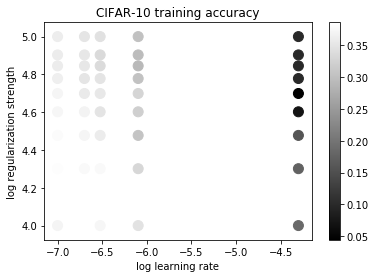

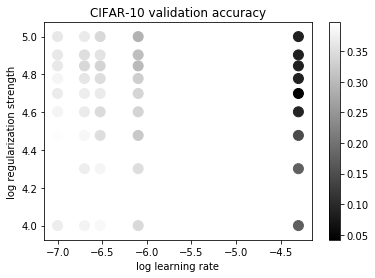

In [45]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
plt.figure()
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()

# plot validation accuracy
plt.figure()
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [46]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.383000


In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*